In [1]:
import geopandas as gpd
import numpy as np
import shapely 
import matplotlib.pyplot as plt
import re
import glob
import os
%matplotlib widget

In [59]:
SH=shapely.Polygon(np.c_[np.array([-180, 180, 180, -180]), np.array([-89, -89, -60,-60])])

track_re = re.compile('IS2_RGT_(\d+)_.*.kml')
tracks={'new':{}, 'old':{}}
for track_file in sorted(glob.glob('IS2_RGT*.kml')):
    track=track_re.search(track_file).group(1)
    tracks['new'][track]=gpd.read_file(track_file, layer=track_file).set_crs(4326).clip(SH).to_crs(3031)

    old_track_file=glob.glob(f'assets/IS2_RGTs_cycle12_date_time/IS2_RGT_{track}*.kml')[0]
    tracks['old'][track]=gpd.read_file(old_track_file, layer=os.path.basename(old_track_file)).set_crs(4326).clip(SH).to_crs(3031)
    print('----')
    print(track_file)
    print(old_track_file)

----
IS2_RGT_0001_cycle0_20-Dec-2022.kml
assets/IS2_RGTs_cycle12_date_time/IS2_RGT_0001_cycle12_23-Jun-2021.kml
----
IS2_RGT_0443_cycle0_18-Jan-2023.kml
assets/IS2_RGTs_cycle12_date_time/IS2_RGT_0443_cycle12_22-Jul-2021.kml
----
IS2_RGT_0885_cycle0_16-Feb-2023.kml
assets/IS2_RGTs_cycle12_date_time/IS2_RGT_0885_cycle12_20-Aug-2021.kml
----
IS2_RGT_0946_cycle0_20-Feb-2023.kml
assets/IS2_RGTs_cycle12_date_time/IS2_RGT_0946_cycle12_24-Aug-2021.kml
----
IS2_RGT_1327_cycle0_17-Mar-2023.kml
assets/IS2_RGTs_cycle12_date_time/IS2_RGT_1327_cycle12_18-Sep-2021.kml


In [60]:
save_file='AA_ TestRGTs_RGT_transition_locations_V2.0.csv'
x_points=gpd.read_file(save_file)
for field in ['rgt','cycle','trans_type']:
    x_points[field]=[*map(int, x_points[field])]
for field in ['lon_req','lat_req']:
    x_points[field]=[*map(float, x_points[field])]
x_points['geometry'] = [shapely.Point([lon, lat]) for lon, lat in zip(x_points['lon_req'], x_points['lat_req'])]
x_points=gpd.GeoDataFrame(x_points)
x_points=x_points.set_crs(4326)
x_points=x_points.cx[:, -90:-50]
x_points=x_points.to_crs(3031)

In [61]:
lat_dist_ot={}

for track in tracks['new']:
    geom_old=tracks['old'][track].geometry[0]
    geom_new=tracks['new'][track].geometry[0]
    geom_ll = tracks['new'][track].to_crs(4326).geometry[0]
    lat_dist_ot[track]=[]
    for xy, ll in zip(geom_new.coords, geom_ll.coords):
        pt = shapely.Point(xy)
        lat_dist_ot[track] += [[ll[1], geom_old.line_locate_point(pt),  geom_old.distance(pt)]]
    lat_dist_ot[track] = np.concatenate([lat_dist_ot[track]], axis=1)

0001
0443
0885
0946
1327


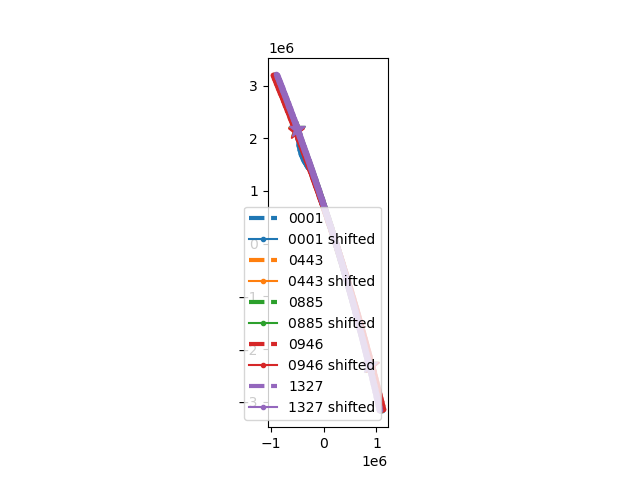

In [63]:
plt.figure()
for track in tracks['new'].keys():
    print(track)
    geom_old=tracks['old'][track].geometry[0]
    geom_new=tracks['new'][track].geometry[0]

    hl = plt.plot(*np.array(geom_old.coords)[:, 0:2].T,'--', label=track, linewidth=3)
    this_color=hl[0].get_color()
    plt.plot(*np.array(geom_new.coords)[:, 0:2].T, color=this_color, marker='.', label=track+' shifted')

    i_xp = x_points.rgt==int(track)
    if np.any(i_xp):
        temp= x_points[i_xp]
        plt.plot(temp.geometry.x, temp.geometry.y,'*', color=this_color, markersize=12)
    
plt.legend()
plt.gca().set_aspect(1)

In [50]:
temp= x_points[i_xp].to_crs(3031)
temp

,rgt,cycle,trans_type,lon_req,lat_req,asc_req,lon_actual,lat_actual,asc_actual,trans_file,crr_id,tdif,conflict,priority,accept,geometry
4622,946,0,1,158.571263,-67.486851,,,,,V2.0,,,,1,y,POINT (904884.136 -2305587.585)
4623,946,0,0,-13.970783,-69.864806,,,,,V2.0,,,,1,y,POINT (-533463.325 2144262.068)


Text(0, 0.5, 'off-tack offset, m')

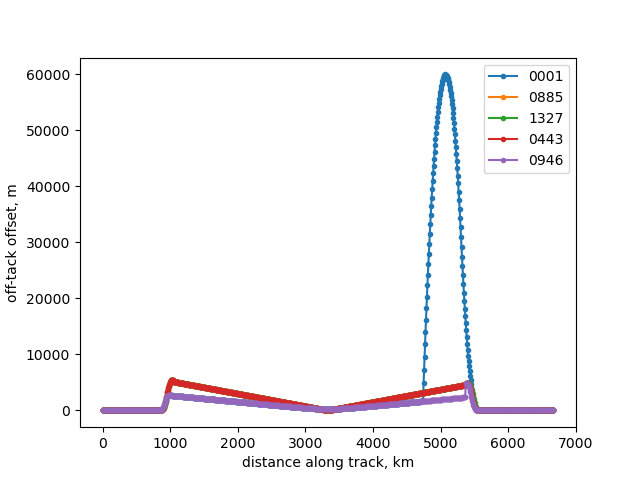

In [6]:
plt.figure()
for track, this_ldo in lat_dist_ot.items():
    plt.plot(this_ldo[:,1]/1000, this_ldo[:,2], label=track, marker='.')
plt.legend()
plt.gca().set_xlabel('distance along track, km')
plt.gca().set_ylabel('off-tack offset, m')

In [ ]:
# send Christine the 200-km buffered Antarctica
# Talk to Tim about why there are different offsets on the tracks



Text(0, 0.5, 'off-tack offset, m')

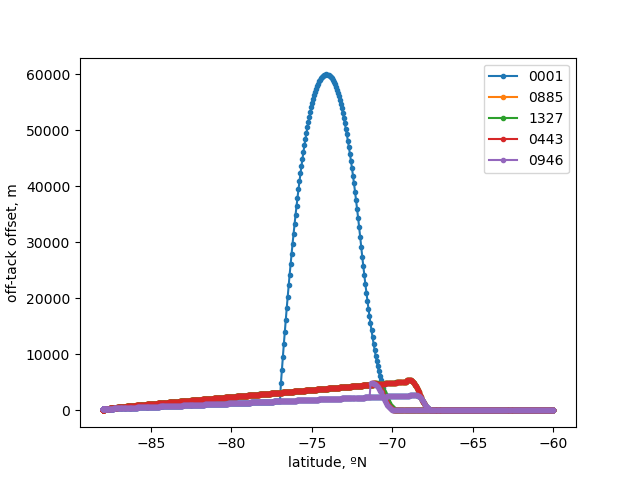

In [14]:
plt.figure()
for track, this_ldo in lat_dist_ot.items():
    plt.plot(this_ldo[:,0], this_ldo[:,2], label=track, marker='.')
plt.legend()
plt.gca().set_xlabel('latitude, ºN')
plt.gca().set_ylabel('off-tack offset, m')

Text(0, 0.5, 'off-tack offset/cos(lat), m')

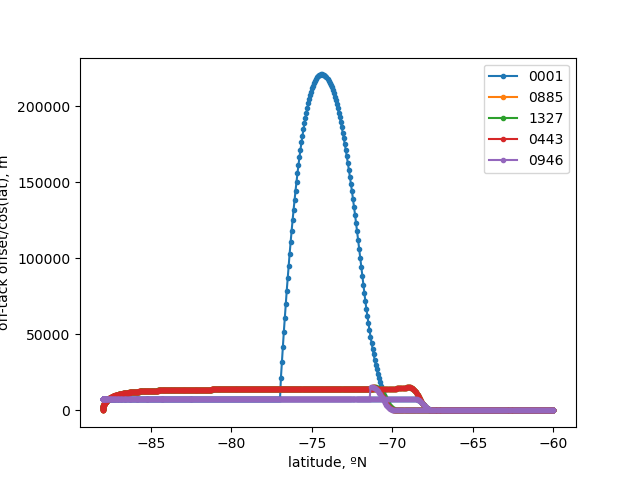

In [56]:
plt.figure()
for track, this_ldo in lat_dist_ot.items():
    plt.plot(this_ldo[:,0], this_ldo[:,2]/np.cos(this_ldo[:,0]*np.pi/180), label=track, marker='.')
plt.legend()
plt.gca().set_xlabel('latitude, ºN')
plt.gca().set_ylabel('off-tack offset/cos(lat), m')

In [58]:
3441/np.cos(62*np.pi/180)

np.float64(7329.517425040111)

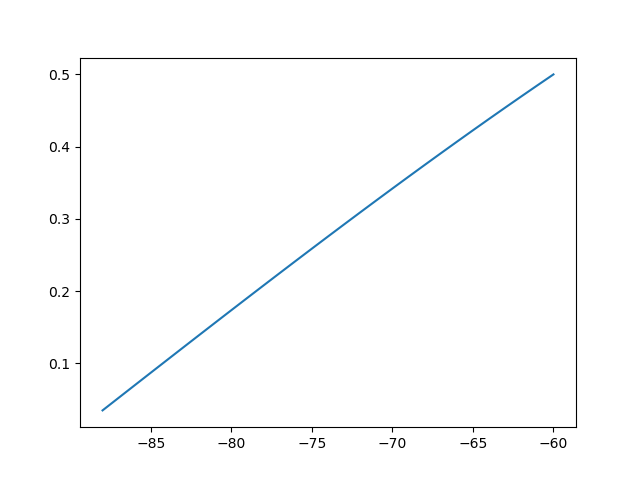

In [12]:
plt.figure()
lat=np.arange(-88, -59)
plt.plot(lat, np.cos(lat*np.pi/180))

In [29]:
! ls -lt *.csv

-rw-r--r-- 1 ben ben 276501 Jul 24 12:12 'AA_ TestRGTs_RGT_transition_locations_V2.0.csv'
-rw-r--r-- 1 ben ben 303920 Jun 30 09:31 'RGT_transition_locations_V2.0 1.csv'


In [40]:
x_points

,rgt,cycle,trans_type,lon_req,lat_req,asc_req,lon_actual,lat_actual,asc_actual,trans_file,crr_id,tdif,conflict,priority,accept,geometry
4,1,0,1,158.827030,-67.527012,,,,,V2.0,,,,1,y,POINT (158.82703 -67.52701)
5,1,0,0,-13.735529,-69.805197,,,,,V2.0,,,,1,y,POINT (-13.73553 -69.8052)
14,3,0,1,-65.034000,-51.967000,0,,,,V2.0,,,,1,y,POINT (-65.034 -51.967)
53,11,0,0,-74.980000,-57.361000,1,,,,V2.0,,,,1,y,POINT (-74.98 -57.361)
77,16,0,0,167.890000,-51.659000,1,,,,V2.0,,,,1,y,POINT (167.89 -51.659)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6521,1337,0,0,-74.350000,-58.151000,1,,,,V2.0,,,,1,y,POINT (-74.35 -58.151)
6545,1342,0,0,168.740000,-51.185000,1,,,,V2.0,,,,1,y,POINT (168.74 -51.185)
6597,1352,0,0,-69.082000,-60.365000,1,,,,V2.0,,,,1,y,POINT (-69.082 -60.365)
6708,1375,0,1,-69.433000,-59.394000,0,,,,V2.0,,,,1,y,POINT (-69.433 -59.394)


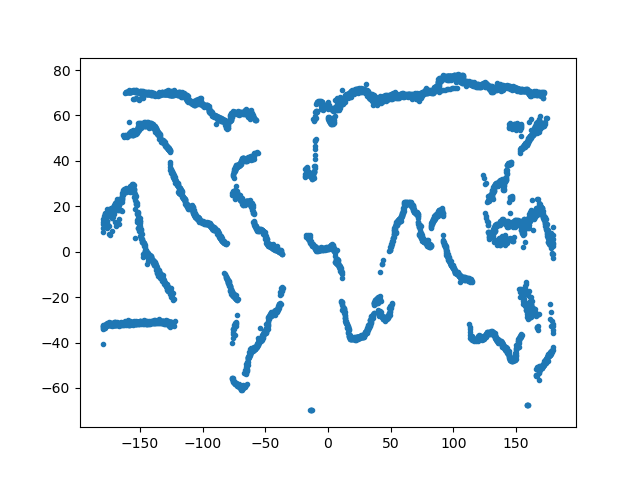

In [32]:
plt.figure()
plt.plot(x_points.geometry.x, x_points.geometry.y,'.')

In [38]:
x_points[x_points.rgt==443+2*442]

,rgt,cycle,trans_type,lon_req,lat_req,asc_req,lon_actual,lat_actual,asc_actual,trans_file,crr_id,tdif,conflict,priority,accept,geometry
6468,1327,0,1,0.526380,1.232000,0,,,,V2.0,,,,1,y,POINT (0.52638 1.232)
6469,1327,0,0,-8.101200,65.810000,0,,,,V2.0,,,,1,y,POINT (-8.1012 65.81)
6470,1327,0,1,170.800000,19.161000,1,,,,V2.0,,,,1,y,POINT (170.8 19.161)
6471,1327,0,0,165.950000,-28.158000,1,,,,V2.0,,,,1,y,POINT (165.95 -28.158)
6472,1327,0,1,159.562760,-67.631874,,,,,V2.0,,,,1,y,POINT (159.56276 -67.63187)
6473,1327,0,0,-13.010794,-69.656588,,,,,V2.0,,,,1,y,POINT (-13.01079 -69.65659)
